# Visualizing the Autoencoder's Learned Embeddings

In this notebook we provide the code we used to generate the figures included in the original blog post. Feel free to expand on this code to investigate further!

In [1]:
import keras
from keras.models import load_model, Model
from keras.layers import Input
import numpy as np
import os, random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

% matplotlib inline

/home/ngundotra/.conda/envs/torchenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_hydra(model_paths):
    """Loads in encoder model, + 3 decoder heads. Assumes encoder_paths = [android, ios, web]
    Returns [encoder, android_head, ios_head, web_head]"""
    if len(model_paths) != 3:
        raise ValueError("must pass 3 paths, one for each model")
        
    # Get encoder from first model_path
    models = [load_model(ep) for ep in model_paths]
    android_model = models[0]
    encoder = Model(android_model.input, android_model.layers[-2].output)
    
    emb_in = Input(shape=(16, 16, 16))
    decoders = []
    for model in models:
        model = Model(emb_in, model.layers[-1](emb_in))
        decoders.append(model)
        
    return [encoder] + decoders

def load_points(data_dir):
    """Loads points from a data dir.
    IMG - numpy features of the image
    GUI - original text
    Points are tuples of form
    (img_path, gui_path) - use `unpack_point` to retrieve data from paths
    """
    imgs = []
    guis = []
    for path in sorted(os.listdir(data_dir)):
        if path.endswith('.gui'):
            guis.append(data_dir + path)
            imgs.append(data_dir + path[:-3] + 'npz')
    points = list(zip(imgs, guis))
    return points

def unpack_point(point):
    """Loads in the underlying data from each point. Returns (np.array, string) which represents
    the GUI and the corresponding DSL description."""
    img = np.load(point[0])['features']
    gui = open(point[1]).read()
    return img, gui

def sample_point(points):
    """Randomly chooses a point from a list of points returns the unpacked form."""
    point = random.choice(points)
    return unpack_point(point)

keras.backend.clear_session()

Succesfully loaded.


## Load Data and Autoencoder

The `BACKEND` argument is mainly meant for default filenames of save configurations for figures generated. It also heads setup some default code. Not strictly necessary to set however.

In [ ]:
BACKEND = 'ios'
DATASETS = ['android', 'ios', 'web']

encoder, android_head, ios_head, web_head = load_hydra(['{}-hydra-model'.format(x) for x in DATASETS])
datasets = [load_points('{}/training_features/'.format(backend)) for backend in DATASETS]
names = {'android': 0, 'ios': 1, 'web': 2}
points = datasets[names[BACKEND]] # some code will default to a dataset called points
print("Succesfully loaded.")

## Generate Interpolations Between Images

The following code is used to generate a GIF which shows a decoder head translating between two GUIs.

(256, 256, 3)
fig size: 72.0 DPI, size in inches [15. 15.]
100% A,  0% B
100% A,  0% B
98% A,  2% B
96% A,  4% B
94% A,  6% B
92% A,  8% B
90% A, 10% B
88% A, 12% B
86% A, 14% B
84% A, 16% B
82% A, 18% B
80% A, 20% B
78% A, 22% B
76% A, 24% B
73% A, 27% B
71% A, 29% B
69% A, 31% B
67% A, 33% B
65% A, 35% B
63% A, 37% B
61% A, 39% B
59% A, 41% B
57% A, 43% B
55% A, 45% B
53% A, 47% B
51% A, 49% B
49% A, 51% B
47% A, 53% B
45% A, 55% B
43% A, 57% B
41% A, 59% B
39% A, 61% B
37% A, 63% B
35% A, 65% B
33% A, 67% B
31% A, 69% B
29% A, 71% B
27% A, 73% B
24% A, 76% B
22% A, 78% B
20% A, 80% B
18% A, 82% B
16% A, 84% B
14% A, 86% B
12% A, 88% B
10% A, 90% B
 8% A, 92% B
 6% A, 94% B
 4% A, 96% B
 2% A, 98% B
 0% A, 100% B
Saved to android-good.gif
100% A,  0% B


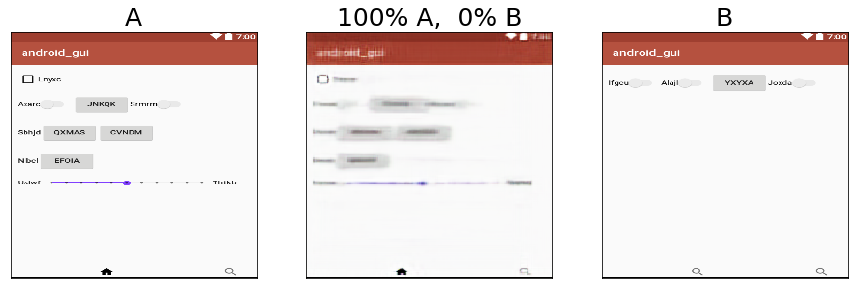

In [142]:
from pylab import rcParams
# set matplotlib rcParams to set fig size
rcParams['figure.figsize'] = 15, 15

def generate_decoder_values(pic_1, pic_2, size, encoder, decoder):
    """Interpolates between pic_1 and pic_2 by interpolating between their embeddings from the autoencoder.
    pic_1(np.array) - from sample_points
    pic_2(same as above)
    size(integer) - number of intermediate images
    """
    emb_1, emb_2 = [encoder.predict(np.expand_dims(pic, axis=0)) for pic in [pic_1, pic_2]]
    decoder_values = []
    # Sample random points between [0, 1], then sort them
    # Effectively taking random jumps from pic_1 to pic_2 as we interpolate between them
    # Looks decent though.
    # C = np.sort(np.random.rand(size))
    
    # Take uniform steps
    C = np.linspace(0, 1, num=size)
    for i in range(C.shape[0]):
        d_val = decoder.predict(C[i] * (emb_2 - emb_1) + emb_1)[0]
        decoder_values.append(d_val)
    print(decoder_values[0].shape)
    return decoder_values, C

def gif_range(pic_1, pic_2, num_imgs, encoder, decoder, fname=None, save=True):
    """
    Makes a GIF that interpolates between pic_1 and pic_2 by sampling from the line between their embeddings.
    
    imgs(list of np.arrays): the intermediary sampled pics
    C(np.array): values sampled to interpolate
    pic_1/pic_2: np.array of actual image
    """
    imgs, C = generate_decoder_values(pic_1, pic_2, num_imgs, encoder, decoder)
    fontdict = {'fontsize':25, 'fontweight': 5}
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(pic_1)
    ax[0].set_title("A", fontdict=fontdict)
    ax[2].imshow(pic_2)
    ax[2].set_title("B", fontdict=fontdict)

    # Query the figure's on-screen size and DPI. Note that when saving the figure to
    # a file, we need to provide a DPI for that separately.
    print('fig size: {0} DPI, size in inches {1}'.format(
        fig.get_dpi(), fig.get_size_inches()))

    def update(i):
        """This is what creates the different frames."""
        label = '{0:2.0f}% A, {1:2.0f}% B'.format(100 - 100 * C[i], 100 * C[i])
        # Useful for debugging
        print(label)
        
        # Intermediary Encoding
        ax[1].imshow(imgs[i])
        ax[1].set_title(label, fontdict)
        
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])
        return ax
    
    anim = FuncAnimation(fig, update, frames=np.arange(0, num_imgs), interval=70)
    if save:
        if not fname:
            fname = '{}-decoder_predictions-new.gif'.format(BACKEND)
        anim.save(fname, dpi=80, writer='imagemagick')
        print("Saved to {}".format(fname))
    plt.show()
    plt.close(fig)


It's currently configured to visualize transitions between Android images. To change this, choose a different dataset and the corresponding decoder. E.g. datasets\[1\] and ios_head will decode iOS images.

In [ ]:
NUM_IMGS = 50
img_1, gui_1 = sample_point(datasets[0])
img_2, gui_2 = sample_point(datasets[0])
gif_range(img_1, img_2, NUM_IMGS, encoder, android_head)

# King - Man + Woman = Queen

The following code is used to generate figures which represent User Interface algebra. Using the embeddings generated by the encoder, we are able to create novel images by adding pieces of other GUIs to a base GUI. An example in the iOS dataset is given below.

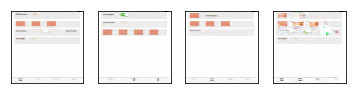

In [23]:
def plot_lin_comb(imgs, weights, encoder, decoder, fname=None, save=False):
    """Plots a combination of photos by creating linear combinations of their embeddings.
    @param decoder: can be list of decoders, or single decoder"""
    
    # Get the image embeddings to interpolate between
    embs = [encoder.predict(np.expand_dims(img, axis=0)) for img in imgs]
    size = len(embs)
    
    if type(decoder) != list:
        decoder = [decoder for i in range(size + 1)]
        
    def predict(idx):
        return decoder[i].predict(embs[idx])[0]

    fig, ax = plt.subplots(1, size + 1)
    pics = []
    for i in range(size):    
        pics.append(predict(i))

    pics = np.array(pics)
    new_emb = np.zeros(embs[0].shape)
    for i in range(size):
        new_emb += weights[i] * embs[i]
    
    new_pic = decoder[-1].predict(new_emb)[0]
    for i in range(size):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(pics[i])
    
    # The last axis displays the resultant combined image
    ax[-1].imshow(new_pic)
    label = 'Emb = '
    for i in range(size):
        label += '{0} * Emb{1} + '.format(weights[i], i + 1)
    label = label[:-2]
    ax[-1].set_xlabel(label)
    ax[-1].set_xticks([]), ax[-1].set_yticks([])
    if save:
        if not fname:
            fname = '{}_add_feature.png'.format(BACKEND)
        plt.savefig(fname, figsize=(8,4), dpi=80)
    
# Example
img_1, gui_1 = sample_point(points)
img_2, gui_2 = sample_point(points)
img_3, gui_3 = sample_point(points)

plot_lin_comb([img_1, img_2, img_3], np.array([1, -1, 1]), encoder, ios_head)

The following code is used to find similar images across all three datasets. Three different measure of similarity are used. However, the results of this exploration are still in its infancy, and does not work that well yet.

In [68]:
def find_most_similar_image(point, points, encoder):
    """Given an image, it finds the image with the most similar embedding. On the fly creates the embeddings
    for all the points in the dataset. Can be slow. Use with caution.
    """
    def cosine_similarity(v1, v2):
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    
    def get_data(pt):
        """Returns the embedding of the point's image"""
        img, gui = unpack_point(pt)
        return encoder.predict(np.expand_dims(img, axis=0))[0]

    # Store our query embedding
    query_emb = get_data(point)
    flattened_emb = query_emb.flatten()
    
    best = 0
    arg_best = None
    # Find closest cosine similar image embedding in points pictures
    for pt in [pt for pt in points if point[0] != pt[0]]:
        emb_new = get_data(pt)
        sim = cosine_similarity(flattened_emb, emb_new.flatten())
        # Useful for debugging
#         print(sim)
        if sim > best:
            best, arg_best = sim, pt
    print("Point given:", point[0],"\nClosest point found:", arg_best[0])
    return best, arg_best

def get_data(pt):
    """Returns the embedding of the point's image"""
    img, gui = unpack_point(pt)
    return encoder.predict(np.expand_dims(img, axis=0))[0]

def cosine_similary(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def l2_loss(v1, v2):
    diff = v1 - v2
    return -np.sqrt(np.dot(diff, diff))

def l1_loss(v1, v2):
    diff = v1 - v2
    return -np.sum(diff)
    
def get_closest_emb(emb, emb_set, metric):
    best = -np.inf
    arg_best = None
    for e in emb_set:
        sim = metric(emb.flatten(), e.flatten())
        if sim > best:
            best, arg_best = sim, e
    return best, arg_best

### Adding iOS components to other iOS images

In [ ]:
# Save the encodings of every image in every dataset
emb_sets = [[get_data(pt) for pt in data] for data in datasets]

# Randomly sampling a point, subtracting its most similar sibling image, and adding a random image
# to create a new image
my_point = random.choice(points)
my_img, my_gui = unpack_point(my_point)
img2add, _ = sample_point(points) 

sim, close_point = find_most_similar_image(my_point, points, encoder)
close_img, _ = unpack_point(close_point)
plot_lin_comb([my_img, close_img, img2add], np.array([1, -1, 1]), encoder, ios_head, fname='ios_add_feature.png', save=True)

### Adding Android components to iOS images

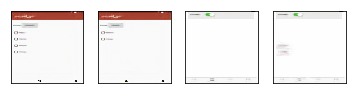

In [28]:
# Subtract 2 similar android photos, then add to ios
web_pt = random.choice(datasets[0])
web_img, _ = unpack_point(web_pt)
sim, close_web = find_most_similar_image(web_pt, datasets[0], encoder)
close_img, _ = unpack_point(close_web)

img2add, _ = sample_point(datasets[1])
plot_lin_comb([web_img, close_img, img2add], np.array([1, -1, 1]), encoder, [android_head, android_head, ios_head, ios_head],
              fname='add_android_diff_ios.png', save=True)

### Cross Platform Visualization

The following code visualizes how different decoder heads see the same GUI. The following results raise the possibility of a universal cross-platform user interface compiler.

19938.096
28881.988


/home/ngundotra/.conda/envs/torchenv/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


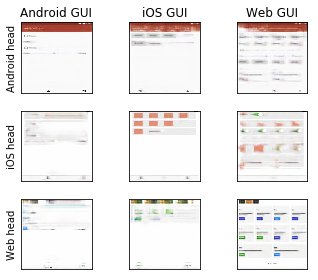

In [92]:
# Find similar images across all three datasets
android_img = random.choice(emb_sets[0])
sim1, close_ios = get_closest_emb(android_img, emb_sets[1], l1_loss)
print(sim1)
sim2, close_web = get_closest_emb(android_img, emb_sets[2], l1_loss)
print(sim2)
decoder = [android_head, ios_head, web_head]

fig, axes = plt.subplots(3, 3)
# imgs = [unpack_point(pt)[0] for pt in [android_img, close_ios, close_web]]
imgs = [android_img, close_ios, close_web]
names = ['Android', 'iOS', 'Web']
for idx, dec in enumerate(decoder):
    axes[idx][0].set_ylabel("{} head".format(names[idx]))
    for i, ax in enumerate(axes[idx, :]):
        ax.imshow(dec.predict(np.expand_dims(imgs[i], axis=0))[0])
        if idx == 0:
            ax.set_title('{} GUI'.format(names[i]))
        ax.set_yticks([])
        ax.set_xticks([])
fig.set_tight_layout(True)
fig.savefig("cross-platform.png", dpi=200, figsize=(8, 8))

### Adding an iOS button to another iOS GUI

The following code reproduces the steps taken to reproduce a specific user interface algebra example given in the original blog post.

Point given: ios/training_features/001B5BD8-0401-4411-A3C4-A745050326C0.npz 
Closest point found: ios/training_features/370BDF37-2371-488B-9E1B-E9DC4E9776D0.npz


/home/ngundotra/.conda/envs/torchenv/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


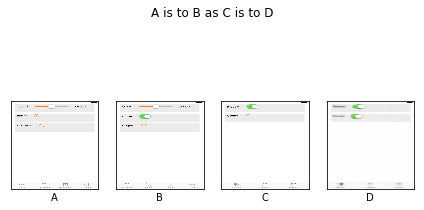

In [107]:
# web_pt = random.choice(datasets[1])
ios_pt = datasets[1][0]
ios_img, _ = unpack_point(ios_pt)
# sim, close_web = find_most_similar_image(web_pt, datasets[1], encoder)
sim, close_ios = find_most_similar_image(ios_pt, datasets[1][1:], encoder)
close_img, _ = unpack_point(close_ios)

img2add, _ = sample_point(datasets[1])

def encode(img):
    return encoder.predict(np.expand_dims(img, 0))[0]

/home/ngundotra/.conda/envs/torchenv/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


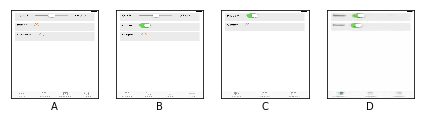

In [109]:
fig, axes = plt.subplots(1,4)
axes[0].imshow(close_img)
axes[0].set_xlabel("A")
axes[1].imshow(web_img)
axes[1].set_xlabel("B")
axes[2].imshow(img2add)
axes[2].set_xlabel("C")
alg = encode(web_img) - encode(close_img) + encode(img2add)
new_img = ios_head.predict(np.expand_dims(alg, 0))[0]
axes[3].imshow(new_img)
axes[3].set_xlabel("D")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# fig.suptitle("A is to B as C is to D")
fig.set_tight_layout(True)
fig.savefig("add_ios_to_ios.png", figsize=(5, 3), dpi=150)
plt.show(fig)
plt.close(fig)